## A Machine Learning Example where we compare Gaussian Elimination with the commonly used method of today

We show that a simple linear neuron can be "learned" with Gaussian elimination, and indeed is much
faster and more accurate upon doing so. (Much of machine learning is non-linear.)

Our model of the universe is that we have an unknown 3-vector

$w = \left[ \begin{array}{c} w_1 \\ w_2 \\ w_3 \end{array} \right]$

that we wish to learn.   We have three 3-vectors $x_1,x_2,x_3$ and the corresponding scalar values
$y_1 = w  \cdot x_1$, $\ y_2 = w  \cdot x_2$,  $\ y_3 = w  \cdot x_3$.  (Caution: The $x_i$ are 3-vectors,
not components.) We will show that Gauassian elimination learns $w$ very quickly, while standard deep learning
approaches (which use a version of  gradient descent currently considered the best known as [ADAM](https://arxiv.org/abs/1412.6980) can require many steps, may be inaccurate, and inconsistent.

One of the issues is how to organize the "x" data and the "y" data.  The "x"s can be the columns or rows of a matrix, or can be a vector of vectors.  Many applications prefer the matrix approach.  The "y"s can be bundled into a vector similarly.

In [1]:
w = rand(3) ## We are setting up a w.  We will know it, but the learning algorithm will only have X and y data below.

3-element Vector{Float64}:
 0.25180627297687963
 0.5918222257721607
 0.641067683043823

In [2]:
using LinearAlgebra

In [3]:
# Here is the data.  Each "x" is a 3-vector.  Each "y" is a number.
n = 3
x1 = rand(3); y1=w ⋅ x1  # We are using the dot product (type \cdot+tab)
x2 = rand(3); y2=w ⋅ x2
x3 = rand(3); y3=w ⋅ x3
# Gather the "x" data into the rows of a matrix and "y" into a vector
X=[x1 x2 x3]'
y=[y1; y2; y3]

3-element Vector{Float64}:
 1.0689046339958201
 1.0755410829151852
 0.8485464788238004

In [4]:
# We check that the linear system for the "unknown" w is X*w = y
X*w-y

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [5]:
## Recover w with Gaussian Elimination
X\y

3-element Vector{Float64}:
 0.2518062729768782
 0.5918222257721599
 0.6410676830438242

In [6]:
w

3-element Vector{Float64}:
 0.25180627297687963
 0.5918222257721607
 0.641067683043823

In [7]:
## Recover w with a machine learning package -- 18.06 students might just want to execute as a black box
using Flux

We show how the same problem is commonly done with machine learning.  Many learning cycles seem to be needed.

In [8]:
# t ... a model to be learned to fit the data
t = Dense(3,1)
loss(t,x,y) = Flux.mse(t(x),y)
opt_state = Flux.setup(ADAM(), t)
Flux.train!(loss, t, Iterators.repeated( (X',y'), 20000), opt_state) # 20000 steps of training
println((t.weight), " : <== estimate after training")

Float32[0.060145017 0.4654307 0.5881613] : <== estimate after training


In [9]:
using Statistics

In [10]:
## Adding more data helps pretty quickly, but many cycles are still important

# sample sizes to test
ns = collect(1:5)

# how many repeats to test at each sample size
nrepeats = 50
nrs = range(start = 1,stop = nrepeats,step = 1)

# initialize matricies to capture results
mses = zeros(length(ns), nrepeats)
shortmses = zeros(length(ns), nrepeats)

for (ix, n) in enumerate(ns)
    for (jx, rn) in enumerate(nrs)
        X = randn(n,3)
        y = X*w
        t = Dense(3,1)
        loss(t,x,y) = Flux.mse(t(x),y)
        opt_state = Flux.setup(ADAM(), t)
        Flux.train!(loss, t, Iterators.repeated( (X',y'), 1000), opt_state) # 1000 steps of training
        shortmses[ix, jx] = Flux.mse(t.weight[1,:], w)
        Flux.train!(loss, t, Iterators.repeated( (X',y'), 20000), opt_state) # 20000 steps of training
        mses[ix, jx] = Flux.mse(t.weight[1,:], w)
    end
end


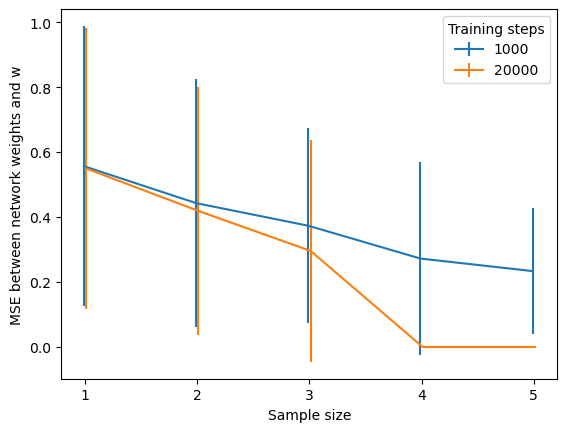

PyObject <matplotlib.legend.Legend object at 0x11932fd90>

In [11]:
using PyPlot
fig, ax = subplots(1)
ax.errorbar(ns .- 0.01,
    mean(shortmses, dims=2)[:, 1],
    yerr=std(shortmses, dims=2)[:, 1],
    label="1000")
ax.errorbar(ns .+ 0.01, 
    mean(mses, dims=2)[:, 1],
    yerr=std(mses, dims=2)[:, 1],
    label="20000")


ax.set_ylabel("MSE between network weights and w")
ax.set_xlabel("Sample size")
ax.set_xticks(ns)
ax.legend(title="Training steps")